In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os


In [2]:
root_dir = os.path.dirname(os.getcwd())
data_filepath = os.path.join(root_dir, 'data/raw_data/boost_df.csv')

df = pd.read_csv(data_filepath)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['trip_start_date'] = pd.to_datetime(df['trip_start_date'])

## Data Quality Checks

In [3]:
# Check missingness and ensure that data types make sense
df_checks = pd.DataFrame(df.dtypes, columns=["data_type"])
df_checks["missing_values"] = df.isna().mean()
df_checks

,data_type,missing_values
trip_id,int64,0.0
timestamp,datetime64[ns],0.0
boost_number,int64,0.0
boost_amount,float64,0.0
base_plus_boost,float64,0.0
claimed,int64,0.0
total_price,float64,0.0
base_price,float64,0.0
total_driver_supply,int64,0.0
metro_area,object,0.0


In [4]:
# Ensure that trip IDs are globally unique (not reused in different metro areas)
assert df.groupby('trip_id').metro_area.nunique().max() == 1

In [5]:
# Ensure that the max boost is always the claimed boost
df['max_boost'] = df.groupby('trip_id').boost_number.transform('max')
df['is_max_boost'] = np.where((df['boost_number'] == df['max_boost']) & (df['boost_number'] > 0), 1, 0)
df['max_boost_claimed'] = np.where(df['is_max_boost'] == df['claimed'], 1, 0)
assert df['max_boost_claimed'].min() == 1

# Clean up
df = df.drop(columns=['max_boost', 'is_max_boost', 'max_boost_claimed'])

## Exploratory Analysis

#### Generate features

In [6]:
df['month'] = df['trip_start_date'].dt.month
df['hour'] = df['trip_start_date'].dt.hour
df['daytime_trip'] = np.where((df['hour'] >= 6) & (df['hour'] <= 10), 1, 0)
df['offer_hour'] = df['timestamp'].dt.hour
df['daytime_offer'] = np.where((df['offer_hour'] >= 6) & (df['offer_hour'] <= 10), 1, 0)
df['lead_time_minutes'] = (df['trip_start_date'] - df['timestamp']).dt.total_seconds() / 60

df['total_boost'] = df['total_price'] - df['base_price']
df['total_boost_pct'] = df['total_boost'] / df['base_price'] * 100

df['offer_start_time'] = df.groupby('trip_id')['timestamp'].transform('min')
df['time_elapsed'] = (df['timestamp'] - df['offer_start_time']).dt.total_seconds() / 60
df['claimed_trip'] = df.groupby('trip_id').claimed.transform('max')
df['mean_base_price'] = df[df.claimed==1].groupby(['trip_start_date']).base_price.transform('mean')
df['mean_total_price'] = df[df.claimed==1].groupby(['trip_start_date']).total_price.transform('mean')

#### What proportion of trips are claimed?

In [7]:
df[['metro_area', 'total_driver_supply', 'time_elapsed', 'daytime_offer', 'claimed', 'claimed_trip']].groupby('metro_area').mean()

,total_driver_supply,time_elapsed,daytime_offer,claimed,claimed_trip
metro_area,,,,,
ATL,299.363987,16.822856,0.186960,0.151437,0.987030
DEN,149.251430,16.658723,0.193756,0.152288,0.984271
DET,119.111332,16.810659,0.195631,0.150723,0.986649
DFW,189.461199,16.900592,0.219000,0.149751,0.986081
LAS,89.430371,16.425491,0.192146,0.153218,0.983430
LAX,748.006318,16.569259,0.193439,0.150547,0.983718
MCL,129.469995,16.748755,0.203578,0.150476,0.985054
MSP,179.163440,16.551413,0.219483,0.151293,0.980036
NYC,249.545861,16.541858,0.185918,0.152832,0.985871


In [8]:
# Check if any boosted trips went unclaimed
assert df[df.claimed_trip == 0].trip_id.value_counts().max() == 1
assert len(df[(df.claimed_trip == 0) & (df.total_price != df.base_price)]) == 0

It appears that all boosted trips were claimed. The few trips that went unclaimed were not boosted. It is uclear if that indicates that drivers are declining the base price or if these rides were simply cancelled before they could be claimed.

#### What is most correlated with claims?

Text(0.5, 1.0, 'Correlation Matrix')

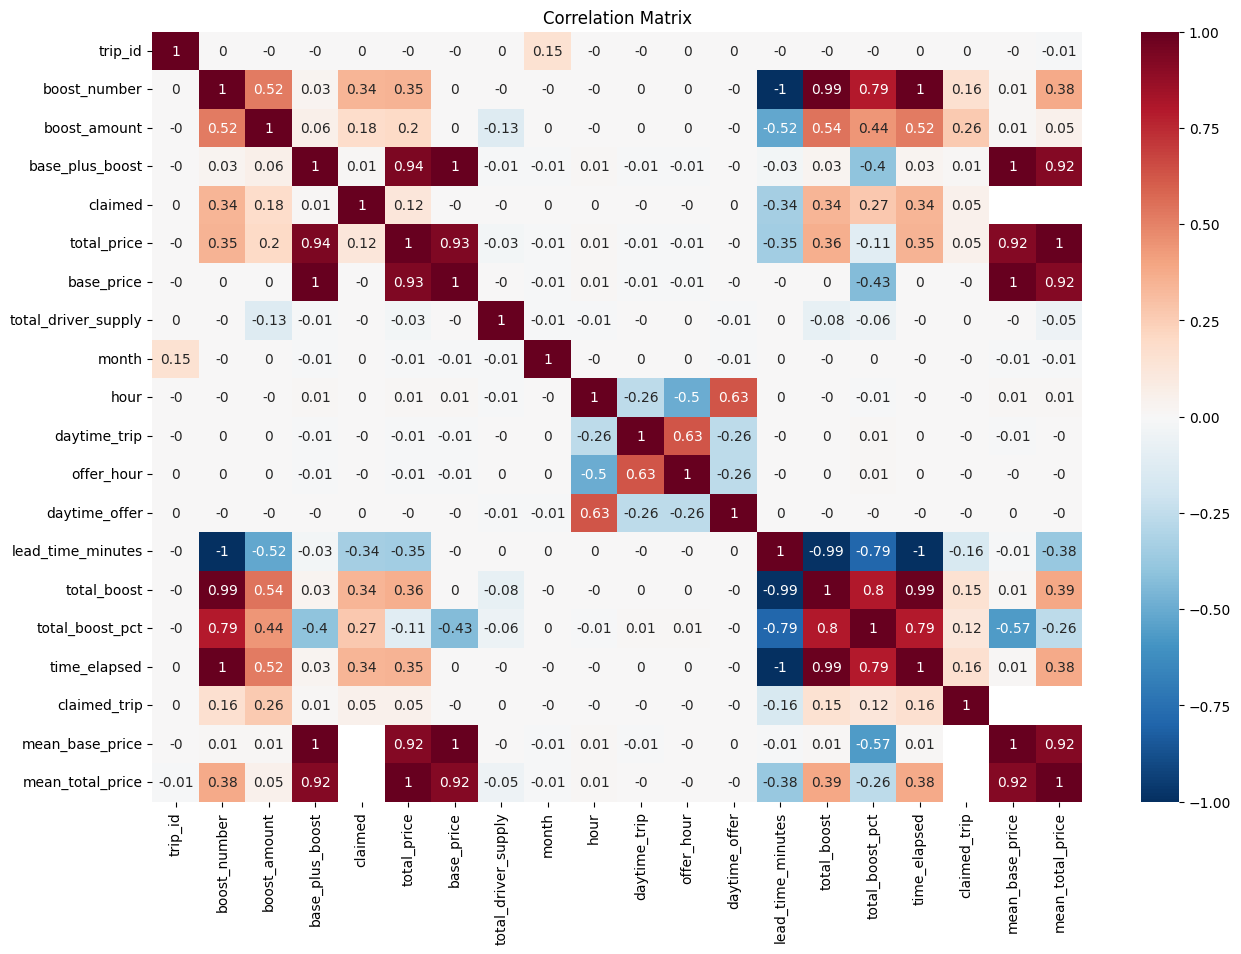

In [9]:
numeric_cols = [n for n in df.select_dtypes(include=['number']).columns]
corrmat = round(df[numeric_cols].corr(), 2)

plt.figure(figsize=(15,10))
sns.heatmap(corrmat, annot=True, cmap="RdBu_r")
plt.title("Correlation Matrix")

#### Are boosts linear or exponential?

Text(0, 0.5, 'Total Boost ($)')

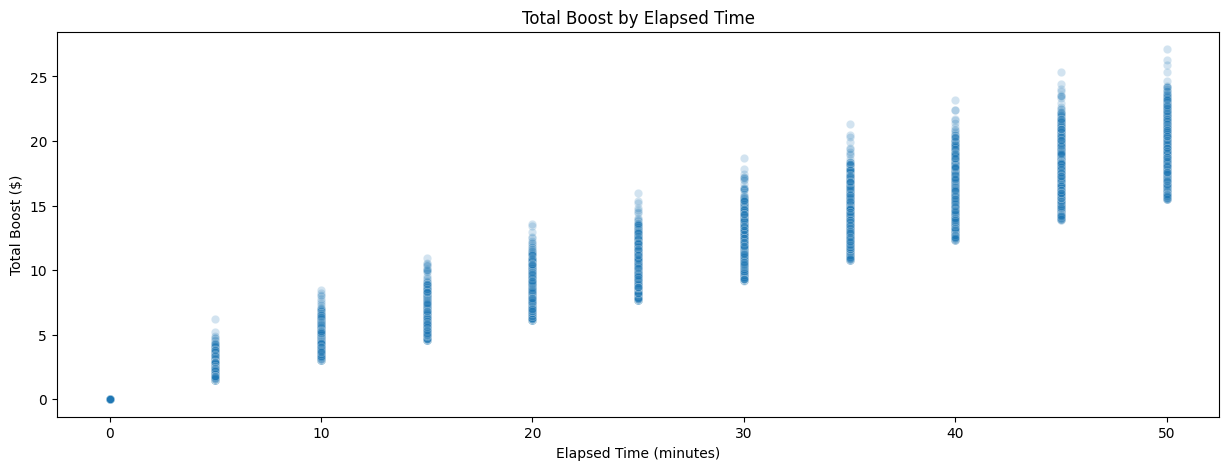

In [10]:
plt.figure(figsize=(15, 5))
sns.scatterplot(data=df, x='time_elapsed', y='total_boost', alpha=.2)
plt.title("Total Boost by Elapsed Time")
plt.xlabel("Elapsed Time (minutes)")
plt.ylabel("Total Boost ($)")

Total boost amount appears to increase linearly, regardless of base price. If we think of the process as a kind of reversed Dutch auction between the drivers, linear increases are probably a reasonable method. What is unclear is whether it is optimal to have linearity in the raw dollar value of increases or in percentage increases (scaled by base price).

In [11]:
df.groupby(['base_price', 'claimed']).boost_amount.mean()

base_price  claimed
10.0        0          1.502618
            1          1.870267
12.0        0          1.502971
            1          1.877359
14.0        0          1.501866
            1          1.871096
16.0        0          1.507927
            1          1.887995
25.0        0          1.510572
            1          1.878152
35.0        0          1.501823
            1          1.873301
48.5        0          1.507000
            1          1.882491
Name: boost_amount, dtype: float64

In [16]:
df.groupby(["base_price", "claimed"]).boost_amount.describe()

count      mean       std   min   25%   50%    75%   max
base_price claimed                                                            
10.0       0        14358.0  1.502618  0.800076  0.00  1.58  1.73  1.920  5.68
           1         2588.0  1.870267  0.285572  1.52  1.67  1.79  1.980  3.71
12.0       0        14407.0  1.502971  0.790598  0.00  1.58  1.73  1.915  5.09
           1         2560.0  1.877359  0.302014  1.51  1.68  1.80  1.980  4.22
14.0       0        14030.0  1.501866  0.792404  0.00  1.58  1.73  1.910  6.71
           1         2509.0  1.871096  0.312284  1.51  1.67  1.79  1.970  4.91
16.0       0        14660.0  1.507927  0.797030  0.00  1.58  1.73  1.920  5.42
           1         2624.0  1.887995  0.329897  1.51  1.68  1.80  2.000  4.73
25.0       0        15138.0  1.510572  0.788476  0.00  1.58  1.73  1.920  6.18
           1         2662.0  1.878152  0.293886  1.52  1.68  1.80  1.990  4.63
35.0       0        14118.0  1.501823  0.800984  0.00  1.58  1.73  1.920  7.12
           1         2542.0  1.873301  0.299500  1.51  1.67  1.79  1.990  3.83
48.5       0        15002.0  1.507000  0.794787  0.00  1.58  1.73  1.920  6.28
           1         2637.0  1.882491  0.317306  1.51  1.68  1.79  1.990  4.33

In [17]:
df.groupby(['boost_number', 'claimed']).boost_amount.describe()

count      mean       std   min   25%   50%   75%  \
boost_number claimed                                                        
0            0        20000.0  0.000000  0.000000  0.00  0.00  0.00  0.00   
1            0        16331.0  1.875826  0.308591  1.51  1.67  1.79  1.98   
             1         1791.0  1.880637  0.334257  1.52  1.68  1.78  1.98   
2            0        14541.0  1.871310  0.314629  1.51  1.67  1.79  1.97   
             1         1790.0  1.873045  0.284782  1.51  1.67  1.80  1.99   
3            0        12695.0  1.871606  0.311326  1.51  1.67  1.79  1.98   
             1         1846.0  1.875016  0.306680  1.52  1.68  1.79  1.97   
4            0        10884.0  1.872686  0.304876  1.51  1.67  1.79  1.98   
             1         1811.0  1.872938  0.284845  1.51  1.68  1.79  1.99   
5            0         9086.0  1.871803  0.302554  1.51  1.67  1.79  1.98   
             1         1798.0  1.858637  0.281999  1.51  1.67  1.79  1.96   
6            0         7273.0  1.879412  0.327226  1.51  1.67  1.79  1.98   
             1         1813.0  1.883409  0.323129  1.51  1.67  1.80  2.00   
7            0         5457.0  1.871246  0.301524  1.51  1.67  1.79  1.98   
             1         1816.0  1.880584  0.316979  1.51  1.67  1.79  1.99   
8            0         3653.0  1.873063  0.307681  1.51  1.67  1.79  1.98   
             1         1804.0  1.886863  0.308245  1.51  1.68  1.80  2.00   
9            0         1793.0  1.877328  0.316554  1.51  1.67  1.79  1.99   
             1         1860.0  1.884435  0.318055  1.52  1.68  1.80  1.99   
10           1         1793.0  1.877295  0.296810  1.52  1.68  1.80  1.99   

                       max  
boost_number claimed        
0            0        0.00  
1            0        6.18  
             1        4.91  
2            0        6.71  
             1        4.54  
3            0        7.12  
             1        3.78  
4            0        5.29  
             1        3.71  
5            0        6.20  
             1        4.46  
6            0        5.68  
             1        4.73  
7            0        4.19  
             1        4.32  
8            0        5.11  
             1        3.98  
9            0        4.15  
             1        4.70  
10           1        4.06

In [33]:
df.groupby('boost_number').boost_amount.mean()

boost_number
0     0.000000
1     1.876302
2     1.871500
3     1.872039
4     1.872722
5     1.869628
6     1.880209
7     1.873578
8     1.877625
9     1.880947
10    1.877295
Name: boost_amount, dtype: float64

Text(0.5, 0.98, 'Total Boost for Claimed Rides, by Type and Base Price')

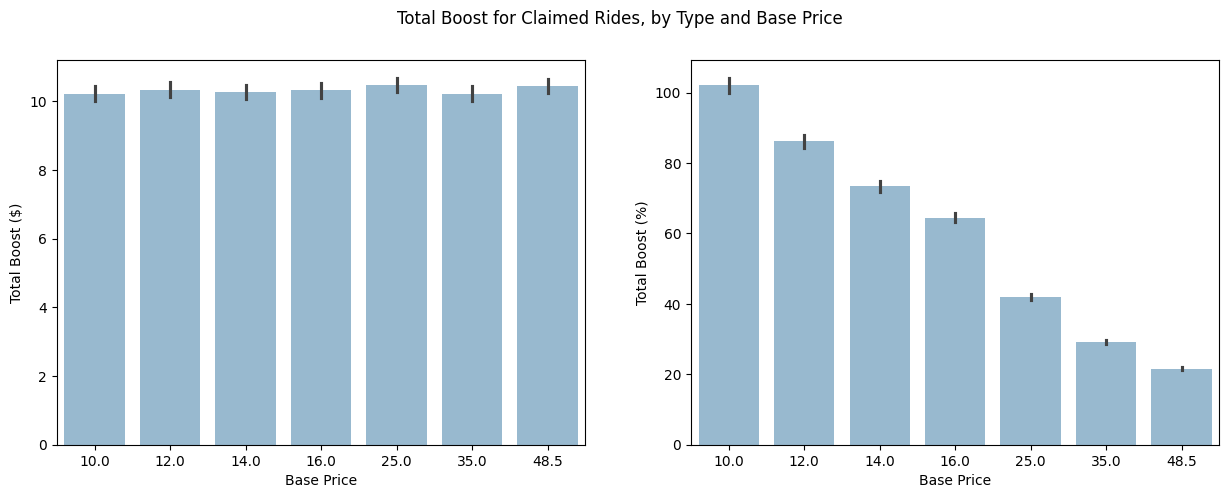

In [34]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.barplot(data=df[df.claimed == 1], y='total_boost', x='base_price', alpha=.5)
plt.xlabel("Base Price")
plt.ylabel("Total Boost ($)")

plt.subplot(1, 2, 2)
sns.barplot(data=df[df.claimed == 1], y='total_boost_pct', x='base_price', alpha=.5)
plt.xlabel("Base Price")
plt.ylabel("Total Boost (%)")

plt.suptitle("Total Boost for Claimed Rides, by Type and Base Price")

#### Seasonality & timing

In [14]:
df[df.claimed==1].time_elapsed.value_counts()

time_elapsed
45.0    1860
15.0    1846
35.0    1816
30.0    1813
20.0    1811
40.0    1804
25.0    1798
50.0    1793
5.0     1791
10.0    1790
Name: count, dtype: int64

In [15]:
# Confirm that there are no cases of a ride being claimed before the 5 minute threshold
len(df[(df.time_elapsed < 5) & (df.claimed == 1)])

0

It is possible that drivers are responding to boosts, but it could simply be that it takes time for rides to be claimed. We currently have 0 rides claimed at the base price, but we only wait 5 minutes before adding boosts. We then add them linearly, regardless of the remaining time before the trip start time. 

In [16]:
season_df = pd.DataFrame(df[df.claimed == 1].groupby('month').total_boost_pct.mean())
season_df['total_boost'] = df[df.claimed == 1].groupby('month').total_boost.mean()
season_df['base_price'] = df[df.claimed == 1].groupby('month').base_price.mean()
season_df['total_price'] = df[df.claimed == 1].groupby('month').total_price.mean()
season_df = season_df.reset_index()
season_df

,month,total_boost_pct,total_boost,base_price,total_price
0,1,59.441525,10.326370,23.063951,33.390321
1,2,61.158836,10.572899,23.145205,33.718103
2,3,59.467732,10.214739,22.801643,33.016381
3,4,59.510372,10.435079,23.463947,33.899026
4,5,60.178619,10.237268,22.409057,32.646325
5,6,59.072224,10.324541,23.076570,33.401110
6,7,58.082526,10.191337,23.359970,33.551307
7,8,57.403781,10.193717,23.618694,33.812411
8,9,60.218635,10.419839,23.155027,33.574866
9,10,61.992149,10.528393,22.638393,33.166786


Text(0.5, 0.98, 'Pricing and Boosts by Month')

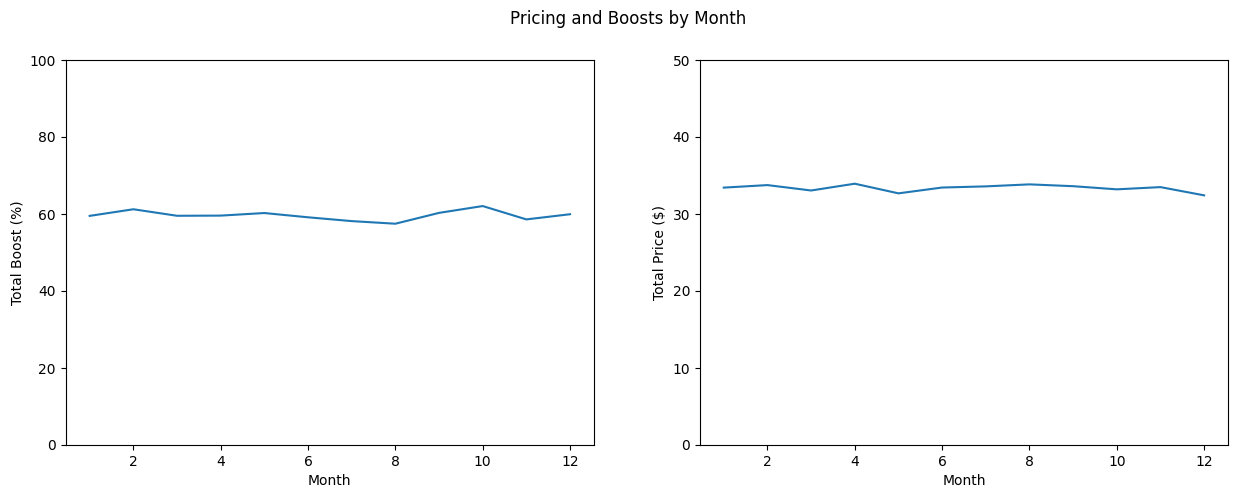

In [17]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.lineplot(data=season_df, x='month', y='total_boost_pct')
plt.ylim(0, 100)
plt.xlabel("Month")
plt.ylabel("Total Boost (%)")

plt.subplot(1, 2, 2)
sns.lineplot(data=season_df, x='month', y='total_price')
plt.ylim(0, 50)
plt.xlabel("Month")
plt.ylabel("Total Price ($)")

plt.suptitle("Pricing and Boosts by Month")


There does not appear to be any clear seasonal trend in pricing for claimed rides.

#### Base price vs. boosts

In [18]:
base_prices = pd.DataFrame(df[df.claimed == 1].groupby('base_price').total_boost.mean())
base_prices['time_elapsed'] = df[df.claimed == 1].groupby('base_price').time_elapsed.mean()
base_prices['lead_time_mean'] = df[df.claimed == 1].groupby('base_price').lead_time_minutes.mean()
base_prices

,total_boost,time_elapsed,lead_time_mean
base_price,,,
10.0,10.206662,27.235317,2132.764683
12.0,10.335684,27.607422,2132.392578
14.0,10.269334,27.461140,2132.538860
16.0,10.312618,27.437119,2132.562881
25.0,10.468325,27.954545,2132.045455
35.0,10.214268,27.226593,2132.773407
48.5,10.455878,27.870686,2132.129314


The strong indication is that drivers display a similar delay in claiming rides, regardless of the base price. This could be because drivers are anticipating boosts. However, given the linearity of boosts (both in amount and timing), it is also plausible that drivers simply take time to claim rides, regardless of the price. The table below shows that the average time to claim rides is nearly identical across the entire range of base prices. If this were a question of price elasticity, you would expect drivers to respond differently to the total boost amount at different base prices (assuming base prices are correlated with the difficulty of the ride).

In [19]:
df[df.claimed==1].time_elapsed.describe()

count    18122.000000
mean        27.545249
std         14.345296
min          5.000000
25%         15.000000
50%         30.000000
75%         40.000000
max         50.000000
Name: time_elapsed, dtype: float64

In [20]:
df[df.claimed == 1].lead_time_minutes.describe() / 60

count    302.033333
mean      35.540913
std        0.239088
min       35.166667
25%       35.333333
50%       35.500000
75%       35.750000
max       35.916667
Name: lead_time_minutes, dtype: float64

In [21]:
df.groupby('base_price').boost_amount.mean()

base_price
10.0    1.558765
12.0    1.559460
14.0    1.557879
16.0    1.565628
25.0    1.565544
35.0    1.558504
48.5    1.563136
Name: boost_amount, dtype: float64

Boosts are sized by absolute amount, not percentage. One would expect them to have a weaker effect on the probability of a claim at higher base prices, but that does not seem to be the case. If you think of this in terms of drivers considering some fixed cost being tied to the base price (e.g. gas + depreciation) and the cost of their time being attached to the boost, it could make some sense.

### Summary

There is little variation in driver behavior between metro areas or across time. Over 98% of rides are claimed, and all claimed rides are claimed within 50 minutes, with an average of 27 minutes. Moreover, all claimed rides are claimed over 35 hours in advance. Given the uncertainty around what is driving claim timing -- driver anticipation of boosts or drivers simply needing more time to decide whether to claim a ride so far in advance -- there is space to experiment with delaying and spreading out boosts. In fact, the strong tendency of drivers to claim rides within an hour, despite there reliably being over 35 hours remaining, suggests that drivers are likely not holding out for boosts.

This conclusion is supported by the fact that the total value of the offer (base price + boosts) is not correlated with the average time it takes drivers to claim rides. On average, claimed rides receive the same boost, due to taking approximately the same time to claim, regardless of the base price. In percentage terms, what this means is that a ride with a base price of 10 dollars ends up paying out a ~100% average boost, whereas a 50 dollar base price ride, on average, pays 20% in boosts. Yet both rides are claimed with roughly the same speed. If all that is going on is drivers waiting for increased incentives, it would have to be the case that that these 100% and 20% incentives carry the same weight. Extrapolated out a bit further, it becomes implausible that 10 dollars carries equal weight in a ride that is difficult enough to justify a 100 dollar base price vs. one that only justifies a 5 dollar base price.


__Preliminary recommendations__:
1. Delay initial boosts
2. Consider increasing intervals between boosts